In [31]:
from tensorboardX import SummaryWriter

In [65]:
from dataset import DatasetFromFolder
from network import Generator, Discriminator
from utils.misc import *

# Data

In [55]:
import torchvision.transforms as transforms

In [56]:
path_data = './data/horse2zebra/'

In [57]:
os.listdir('./data/horse2zebra/')

['.DS_Store', 'testA', 'trainB', 'testB', 'trainA']

In [58]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [59]:
trainA_dataset = DatasetFromFolder(path_data, 'trainA', transform=transform)
trainA_dataloader = data.DataLoader(trainA_dataset, batch_size = 4)

trainB_dataset = DatasetFromFolder(path_data, 'trainB', transform=transform)
trainB_dataloader = data.DataLoader(trainB_dataset, batch_size = 4)

testA_dataset = DatasetFromFolder(path_data, 'testA', transform=transform)
testA_dataloader = data.DataLoader(testA_dataset, batch_size = 4)

testB_dataset = DatasetFromFolder(path_data, 'testB', transform=transform)
testB_dataloader = data.DataLoader(testB_dataset, batch_size = 4)

## Model

In [60]:
## Test
img = iter(trainA_dataloader).next()

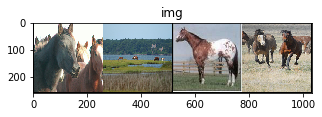

In [63]:
imshow(torchvision.utils.make_grid(img.data.cpu(), normalize=True), "img", size=(5,5))

In [48]:
img.size()

torch.Size([4, 3, 256, 256])

In [49]:
g_a = Generator(3, 3, 64)
g_b = Generator(3, 3, 64)

In [50]:
g_a(img).size()

torch.Size([4, 3, 256, 256])

In [51]:
d_a = Discriminator(3, 1, 64)
d_b = Discriminator(3, 1, 64)

In [52]:
d_a(img).size()

torch.Size([4, 1, 13, 13])

## Train

In [39]:
import itertools
import torch.optim as optim
import torchvision

In [32]:
writer = SummaryWriter()

In [21]:
## loss, optim
mse_loss = nn.MSELoss()
l1_loss = nn.L1Loss()

g_optim = optim.Adam(itertools.chain(g_a.parameters(), g_b.parameters()),
                                    lr=0.0001, betas=(0.5, 0.999))
d_a_optim = optim.Adam(d_a.parameters(), lr=0.0001, betas=(0.5, 0.999))
d_b_optim = optim.Adam(d_b.parameters(), lr=0.0001, betas=(0.5, 0.999))

In [22]:
num_epoch = 1

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Epoch [1/1], Step [1/267], loss_D_A: 0.2640, loss_D_B: 0.2740, loss_G: 1.0272


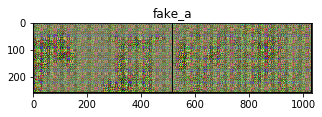

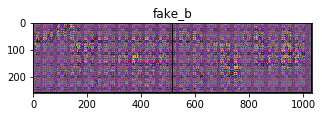

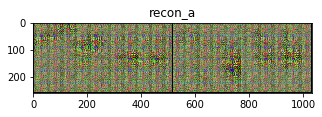

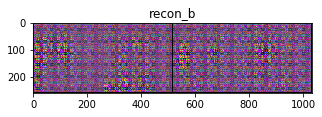

Save Model !!
Save Model !!
Save Model !!
Save Model !!


In [75]:
for epoch in range(num_epoch):
    for idx, (real_a, real_b) in enumerate(zip(trainA_dataloader, trainB_dataloader)):
        real_a = real_a.to(device)
        real_b = real_b.to(device)
        
        # train G_A
        fake_a = g_a(real_b)
        output_a = d_a(fake_a)
        loss_g_a = mse_loss(output_a, torch.ones(output_a.size()).to(device))
        
        # train G_B
        fake_b = g_b(real_a)
        output_b = d_b(fake_b)
        loss_g_b = mse_loss(output_b, torch.ones(output_b.size()).to(device))
        
        # cycle loss
        recon_a = g_a(fake_b)
        recon_b = g_b(fake_a)
        loss_cycle_a = l1_loss(recon_a, real_a)
        loss_cycle_b = l1_loss(recon_b, real_b)
        
        loss_g = loss_g_a + loss_g_b + 0.5 * (loss_cycle_a + loss_cycle_b)
        
        g_optim.zero_grad()
        loss_g.backward()
        g_optim.step()
        
        # train D_A
        output_real_a = d_a(real_a)
        output_fake_a = d_a(fake_a.detach())
        loss_real_d_a = mse_loss(output_real_a, torch.ones(output_real_a.size()).to(device))
        loss_fake_d_a = mse_loss(output_fake_a, torch.zeros(output_fake_a.size()).to(device))
        loss_d_a = 0.5 * (loss_real_d_a + loss_fake_d_a)
        
        d_a_optim.zero_grad()
        loss_d_a.backward()
        d_a_optim.step()
        
        # train D_B
        output_real_b = d_b(real_b)
        output_fake_b = d_b(fake_b.detach())
        loss_real_d_b = mse_loss(output_real_b, torch.ones(output_real_b.size()).to(device))
        loss_fake_d_b = mse_loss(output_fake_b, torch.zeros(output_fake_b.size()).to(device))
        loss_d_b = 0.5 * (loss_real_d_b + loss_fake_d_b)
        
        d_b_optim.zero_grad()
        loss_d_b.backward()
        d_b_optim.step()
        
        # logging
        if idx % 1 == 0:
            len_total = len(trainA_dataloader)
            
            print('Epoch [%d/%d], Step [%d/%d], loss_D_A: %.4f, loss_D_B: %.4f, loss_G: %.4f'
                 % (epoch+1, num_epoch, idx+1, len_total, 
                    loss_d_a.item(), loss_d_b.item(), loss_g.item()))
            
            # image logging
            writer.add_image('fake_a', fake_a[0,:,:,:], epoch * len_total + idx)
            writer.add_image('fake_b', fake_b[0,:,:,:], epoch * len_total + idx)
            writer.add_image('recon_a', recon_a[0,:,:,:], epoch * len_total + idx)
            writer.add_image('recon_b', recon_b[0,:,:,:], epoch * len_total + idx)
            
            # scala logging
            writer.add_scalar('loss_D_A', loss_d_a.item(), epoch * len_total + idx)
            writer.add_scalar('loss_D_B', loss_d_b.item(), epoch * len_total + idx)
            writer.add_scalar('loss_G', loss_g.item(), epoch * len_total + idx)
            
            # show image
            imshow(torchvision.utils.make_grid(fake_a.data.cpu(), normalize=True), "fake_a", size=(5,5))
            imshow(torchvision.utils.make_grid(fake_b.data.cpu(), normalize=True), "fake_b", size=(5,5))
            imshow(torchvision.utils.make_grid(recon_a.data.cpu(), normalize=True), "recon_a", size=(5,5))
            imshow(torchvision.utils.make_grid(recon_b.data.cpu(), normalize=True), "recon_b", size=(5,5))
            
            # save model
            save_model('model', 'GA', g_a, {'iter': epoch * len_total + idx})
            save_model('model', 'GB', g_b, {'iter': epoch * len_total + idx})
            save_model('model', 'DA', d_a, {'iter': epoch * len_total + idx})
            save_model('model', 'DB', d_b, {'iter': epoch * len_total + idx})
        break
        

In [74]:
fake_a[0,:,:,:].size()

torch.Size([3, 256, 256])